<a href="https://colab.research.google.com/github/glevans/pdbe-api-training/blob/master/PDBe_2023_release_stats.ipynb" target="_parent">Open In Colab</a>

# Setting-up & downloading statistics for 2023

Making imports and setting global variables

In [1]:
import requests # used for getting data from a URL
from pprint import pprint # pretty print
import pandas as pd # used for turning results into mini databases
!pip install solrq
from solrq import Q # used to turn result queries into the right format
import numpy as np

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?" # the rest of the URL used for PDBe's search API.


A function to get data from PDBe's search API

In [2]:
def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    makes a get request to the PDBe API
    :param dict search_dict: the terms used to search
    :param number_of_rows: number or rows to return - limited to 10
    :return dict: response JSON
    """
    if 'rows' not in search_dict:
        search_dict['rows'] = number_of_rows
    search_dict['wt'] = 'json'
    if group_pdb == True:
      search_dict['group'] = 'true'
      search_dict['group.field'] = 'pdb_id'
      search_dict['group.ngroups'] = 'true'
    pprint(search_dict)
    pprint(search_url)
    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, response.text))

    return {}

Formatting the search terms
This will allow us to use human readable search terms and this function will make a URL that the search API can handle.

In [3]:
def format_search_terms(search_terms, filter_terms=None):
    ret = {'q': str(search_terms)}
    if filter_terms:
        fl = '{}'.format(','.join(filter_terms))
        ret['fl'] = fl
    return ret

Getting useful data out of the search
This function will run the search and will return a list of the results
Two versions - one returning entity results, the other grouping by PDB ID

In [4]:
def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    search_term = format_search_terms(search_terms, filter_terms)
    #print(search_term)
    response = make_request(search_term, number_of_rows, group_pdb)
    results = response.get('response', {}).get('docs', [])
    #results = response.get('response', {}).get('docs', [])
    #print('Number of results: {}'.format(len(results)))
    return results
    #return response

In [5]:
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    search_term = format_search_terms(search_terms, filter_terms)
    #print(search_term)
    response = make_request(search_term, number_of_rows, group_pdb)
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    results = []
    for group in preresults:
      docs = group.get('doclist', {}).get('docs', [])
      for doc in docs:
        results.append(doc)
    #print('Number of results: {}'.format(len(results)))
    return results

Search for released entries by year:
(added filtering to get back only fields interesting in this notebook)

In [6]:
search_terms = Q(status="REL", release_year=2023)
filter_terms = ['pdb_id', 'experimental_method', 'resolution', 'em_resolution', 'image_processing_id','journal', 'refinement_software', 'synchrotron_site', 'em_electron_detection', 'cath_homologous_superfamily', 'assembly_composition', 'processing_site']
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)
pprint(results[:5])

{'fl': 'pdb_id,experimental_method,resolution,em_resolution,image_processing_id,journal,refinement_software,synchrotron_site,em_electron_detection,cath_homologous_superfamily,assembly_composition,processing_site',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL AND release_year:2023',
 'rows': 20000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
[{'assembly_composition': ['protein structure'],
  'experimental_method': ['X-ray diffraction'],
  'journal': 'To be published',
  'pdb_id': '7wj1',
  'processing_site': 'PDBJ',
  'refinement_software': ['REFMAC'],
  'resolution': 0.86,
  'synchrotron_site': ['SPring-8']},
 {'assembly_composition': ['RNA structure'],
  'experimental_method': ['X-ray diffraction'],
  'journal': 'Nucleic Acids Res',
  'pdb_id': '7wia',
  'processing_site': 'PDBJ',
  'refinement_software': ['PHENIX'],
  'resolution': 3.22,
  'synchrotron_site': ['SSRF']},
 {'assembly_composition': ['protein/protein complex']

Change lists to strings to help with graphing

In [7]:
def change_lists_to_strings(results):
    """
    input - list of results from search
    output - list of results with lists changed into strings
    """
    for row in results:
        for data in row:
            if type(row[data]) == list:
                # if there are any numbers in the list change them into strings
                row[data] = [str(a) for a in row[data]]
                # unique and sort the list and then change the list into a string
                row[data] = ','.join(sorted(list(set(row[data]))))

    return results

We can use a Python package called Pandas to change the results into a mini database - called a DataFrame.

In [8]:
def pandas_dataset(list_of_results):
    results = change_lists_to_strings(list_of_results) # we have added our function to change lists to strings
    df = pd.DataFrame(results)

    return df

Functions to count results and plot them on a graph

In [9]:
def pandas_count(list_of_results, column_to_group_by):
    df = pandas_dataset(list_of_results)
    ds = df.groupby(column_to_group_by)['pdb_id'].nunique().sort_values(ascending=False)
    return ds

def pandas_plot(list_of_results, column_to_group_by, graph_type='bar', top10=False):
    ds = pandas_count(list_of_results=list_of_results, column_to_group_by=column_to_group_by)
    if top10 == True:
      ds = ds.iloc[:10]
    ds.plot(kind=graph_type)

def pandas_plot_top10(list_of_results, column_to_group_by, graph_type='bar'):
    ds = pandas_count(list_of_results=list_of_results, column_to_group_by=column_to_group_by)
    ds = ds.iloc[:10]
    ds.plot(kind=graph_type)

def pandas_mean_plot(list_of_results, column_to_group_by, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df.groupby(column_to_group_by).mean().plot(kind=graph_type)


# Experimental methods per year

Basic plotting of experimental method per year

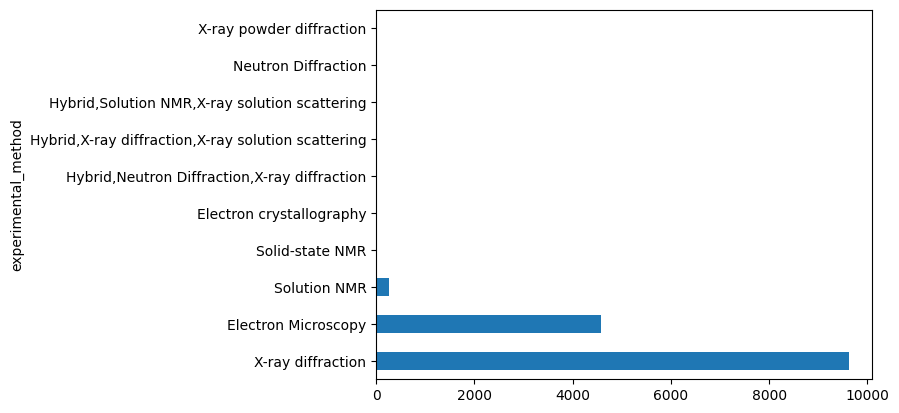

In [10]:
pandas_plot(list_of_results=results, column_to_group_by='experimental_method', graph_type='barh')

Basic 'table' of experimental method per year in the plot above

In [11]:
pandas_count(list_of_results=results, column_to_group_by='experimental_method')

experimental_method
X-ray diffraction                                     9616
Electron Microscopy                                   4568
Solution NMR                                           253
Solid-state NMR                                         19
Electron crystallography                                14
Hybrid,Neutron Diffraction,X-ray diffraction            10
Hybrid,X-ray diffraction,X-ray solution scattering       3
Hybrid,Solution NMR,X-ray solution scattering            2
Neutron Diffraction                                      2
X-ray powder diffraction                                 1
Name: pdb_id, dtype: int64

# Journals published in per year

Basic plotting of journals per year

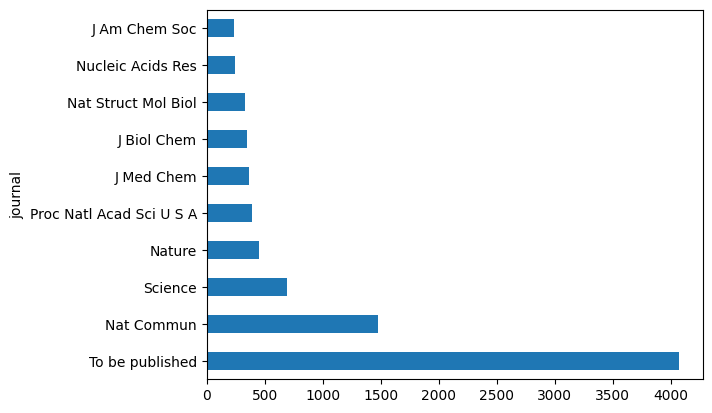

In [12]:
pandas_plot(list_of_results=results, column_to_group_by='journal', graph_type='barh', top10=True)

Basic 'table' of journals per year

In [13]:
pandas_count(list_of_results=results, column_to_group_by='journal')

journal
To be published             4070
Nat Commun                  1474
Science                      691
Nature                       447
Proc Natl Acad Sci U S A     393
                            ... 
Chemistryselect                1
PLoS Comput Biol               1
Immunohorizons                 1
Org Lett                       1
EBioMedicine                   1
Name: pdb_id, Length: 409, dtype: int64

# Refinement software used per year

Basic plotting of refinement_software per year

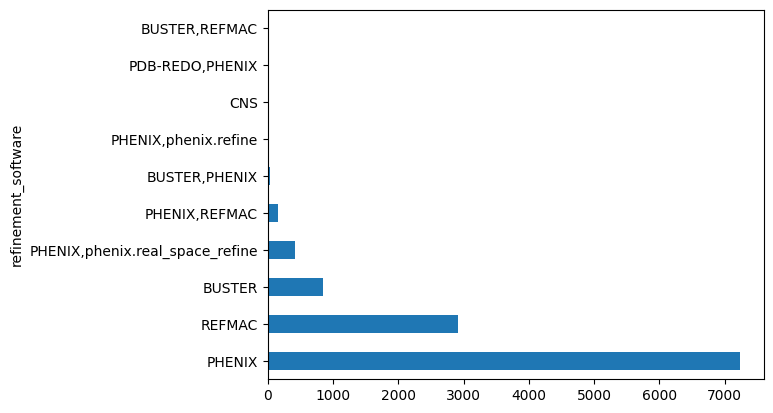

In [14]:
pandas_plot(list_of_results=results, column_to_group_by='refinement_software', graph_type='barh', top10=True)

Basic 'table' of refinement software per year

In [15]:
pandas_count(list_of_results=results, column_to_group_by='refinement_software')

refinement_software
PHENIX                             7239
REFMAC                             2907
BUSTER                              838
PHENIX,phenix.real_space_refine     410
PHENIX,REFMAC                       149
BUSTER,PHENIX                        35
PHENIX,phenix.refine                 10
CNS                                   8
PDB-REDO,PHENIX                       7
BUSTER,REFMAC                         7
PDB-REDO,REFMAC                       6
SHELX                                 4
SHELXL                                4
PDB-REDO                              3
MAIN                                  3
ISOLDE,PHENIX,REFMAC                  2
ISOLDE,PHENIX                         2
PRIME-X                               2
autoBUSTER                            2
nCNS                                  2
BUSTER,PDB-REDO,PHENIX                1
PHENIX,SHELXL                         1
PHENIX,Xtrapol8                       1
GSAS                                  1
CNX                 

Setting up new search for only X-ray

In [16]:
search_terms = Q(status="REL", release_year=2023, experimental_method="X-ray diffraction")
filter_terms = ['pdb_id','refinement_software']
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
xray_results = run_grouped_search(search_terms, filter_terms, number_of_rows=20000, group_pdb=True)
pprint(xray_results[:5])

{'fl': 'pdb_id,refinement_software',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL AND release_year:2023 AND experimental_method:X\\-ray\\ '
      'diffraction',
 'rows': 20000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
[{'pdb_id': '7wj1', 'refinement_software': ['REFMAC']},
 {'pdb_id': '7wia', 'refinement_software': ['PHENIX']},
 {'pdb_id': '7w91', 'refinement_software': ['PHENIX']},
 {'pdb_id': '7w5l', 'refinement_software': ['PHENIX']},
 {'pdb_id': '8j0w', 'refinement_software': ['REFMAC']}]


In [17]:
pandas_count(list_of_results=xray_results, column_to_group_by='refinement_software')

refinement_software
PHENIX                    5727
REFMAC                    2817
BUSTER                     838
PHENIX,REFMAC              149
BUSTER,PHENIX               35
PDB-REDO,PHENIX              7
BUSTER,REFMAC                7
CNS                          7
PDB-REDO,REFMAC              6
SHELX                        4
SHELXL                       4
MAIN                         3
PDB-REDO                     3
ISOLDE,PHENIX,REFMAC         2
ISOLDE,PHENIX                2
PHENIX,phenix.refine         2
PRIME-X                      2
autoBUSTER                   2
nCNS                         2
BUSTER,PDB-REDO,PHENIX       1
CNX                          1
PHENIX,SHELXL                1
PHENIX,Xtrapol8              1
CNS,PHENIX,REFMAC            1
phenix.refine                1
Name: pdb_id, dtype: int64

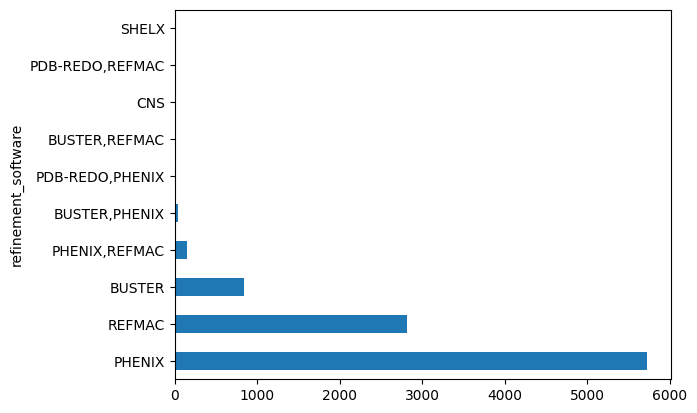

In [18]:
pandas_plot(list_of_results=xray_results, column_to_group_by='refinement_software', graph_type='barh', top10=True)

# Synchrotron used per year

Basic plotting of synchrotron_site per year

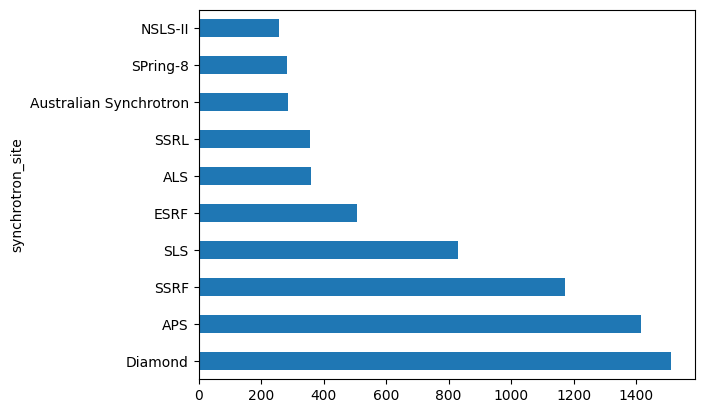

In [19]:
pandas_plot(list_of_results=results, column_to_group_by='synchrotron_site', graph_type='barh', top10=True)

Basic 'table' of synchrotron_site per year

In [20]:
pandas_count(list_of_results=results, column_to_group_by='synchrotron_site')

synchrotron_site
Diamond                           1511
APS                               1415
SSRF                              1171
SLS                                831
ESRF                               508
ALS                                360
SSRL                               355
Australian Synchrotron             287
SPring-8                           284
NSLS-II                            257
BESSY                              223
PETRA III, EMBL c/o DESY           217
Photon Factory                     213
PAL/PLS                            203
SOLEIL                             199
PETRA III, DESY                    156
NSRRC                              147
ALBA                               140
CLSI                               108
ELETTRA                             97
MAX IV                              69
SwissFEL ARAMIS                     56
NFPSS                               31
SLAC LCLS                           29
CHESS                               27
SACLA   

# EM detectors used per year

Basic plotting of em_electron_detection per year

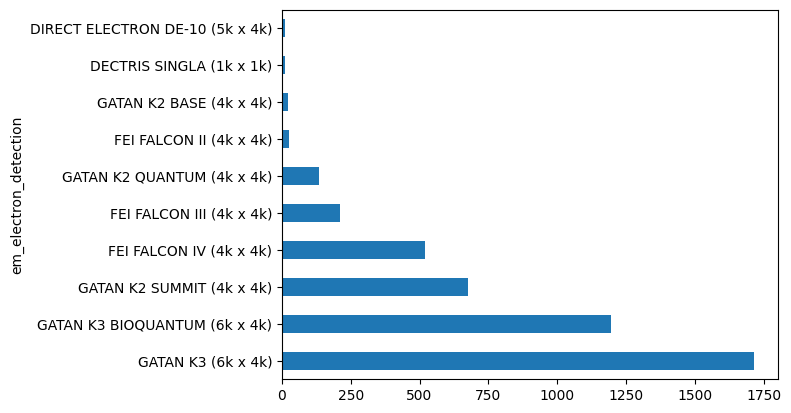

In [21]:
pandas_plot(list_of_results=results, column_to_group_by='em_electron_detection', graph_type='barh', top10=True)

Basic 'table' of em_electron_detection used per year

In [22]:
pandas_count(list_of_results=results, column_to_group_by='em_electron_detection')

em_electron_detection
GATAN K3 (6k x 4k)                                          1716
GATAN K3 BIOQUANTUM (6k x 4k)                               1196
GATAN K2 SUMMIT (4k x 4k)                                    675
FEI FALCON IV (4k x 4k)                                      521
FEI FALCON III (4k x 4k)                                     210
GATAN K2 QUANTUM (4k x 4k)                                   134
FEI FALCON II (4k x 4k)                                       24
GATAN K2 BASE (4k x 4k)                                       21
DECTRIS SINGLA (1k x 1k)                                      11
DIRECT ELECTRON DE-10 (5k x 4k)                               11
GATAN K2 QUANTUM (4k x 4k),GATAN K3 BIOQUANTUM (6k x 4k)      10
DIRECT ELECTRON DE-64 (8k x 8k)                                9
TFS FALCON 4i (4k x 4k)                                        7
FEI EAGLE (4k x 4k)                                            6
OTHER                                                          5
GAT

# Composition of structure solved per year

Basic plotting of assembly_composition per year

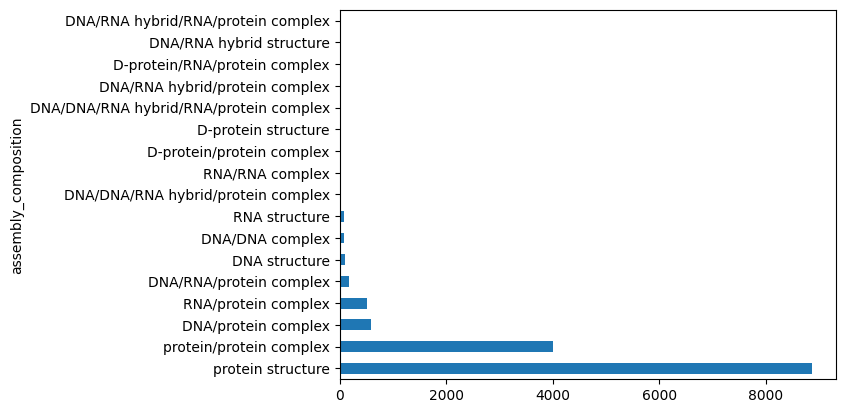

In [32]:
pandas_plot(list_of_results=results, column_to_group_by='assembly_composition', graph_type='barh')

Basic 'table' of data per year of information in above plot

In [24]:
pandas_count(list_of_results=results, column_to_group_by='assembly_composition')

assembly_composition
protein structure                         8865
protein/protein complex                   4011
DNA/protein complex                        582
RNA/protein complex                        515
DNA/RNA/protein complex                    176
DNA structure                              100
DNA/DNA complex                             87
RNA structure                               75
DNA/DNA/RNA hybrid/protein complex          23
RNA/RNA complex                             17
D-protein/protein complex                   12
D-protein structure                          4
DNA/DNA/RNA hybrid/RNA/protein complex       2
DNA/RNA hybrid/protein complex               1
D-protein/RNA/protein complex                1
DNA/RNA hybrid structure                     1
DNA/RNA hybrid/RNA/protein complex           1
Name: pdb_id, dtype: int64

# More analysis per year

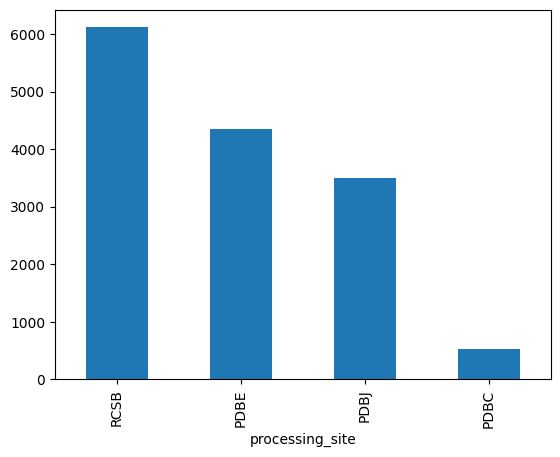

In [25]:
pandas_plot(list_of_results=results, column_to_group_by='processing_site')

Setting up new search for only X-ray

In [26]:
search_terms = Q(status="REL", release_year=2023, experimental_method="X-ray diffraction")
filter_terms = ['pdb_id','resolution',]
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
xray_results = run_grouped_search(search_terms, filter_terms, number_of_rows=10000, group_pdb=True)
pprint(xray_results[:5])

{'fl': 'pdb_id,resolution',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL AND release_year:2023 AND experimental_method:X\\-ray\\ '
      'diffraction',
 'rows': 10000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
[{'pdb_id': '7wj1', 'resolution': 0.86},
 {'pdb_id': '7wia', 'resolution': 3.22},
 {'pdb_id': '7w91', 'resolution': 3.292},
 {'pdb_id': '7w5l', 'resolution': 2.5},
 {'pdb_id': '8j0w', 'resolution': 1.6}]


Setting function to plotted binned data

In [27]:
def pandas_plot_binned(list_of_results, column_to_group_by, bin_cat, bin_range, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df[bin_cat] = pd.cut(df[column_to_group_by],bin_range)
    #print(df.head(5))
    ds = df.groupby(bin_cat)['pdb_id'].nunique()
    #print(ds)
    ds.plot(kind=graph_type)


Plot X-ray resolution by bins

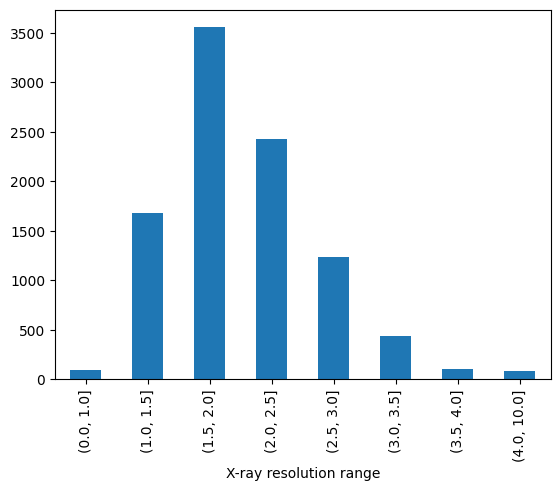

In [28]:
bin_cat = 'X-ray resolution range'
bin_range = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 10]
pandas_plot_binned(list_of_results=xray_results, column_to_group_by='resolution', bin_cat=bin_cat, bin_range=bin_range)

Setting up new search for only EM

In [29]:
search_terms = Q(status="REL", release_year=2023, experimental_method='Electron Microscopy')
filter_terms = ['pdb_id','em_resolution']
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
em_results = run_grouped_search(search_terms, filter_terms, number_of_rows=10000, group_pdb=True)
pprint(em_results[:5])

{'fl': 'pdb_id,em_resolution',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL AND release_year:2023 AND experimental_method:Electron\\ '
      'Microscopy',
 'rows': 10000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
[{'em_resolution': [2.65], 'pdb_id': '7whd'},
 {'em_resolution': [2.95], 'pdb_id': '8j3r'},
 {'em_resolution': [3.1], 'pdb_id': '8j01'},
 {'em_resolution': [2.52], 'pdb_id': '8iwz'},
 {'em_resolution': [2.97], 'pdb_id': '8iw7'}]


In [30]:
def pandas_plot_binned_float(list_of_results, column_to_group_by, bin_cat, bin_range, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df = df.drop([339,391,597,4028])
    df[column_to_group_by] = pd.to_numeric(df[column_to_group_by])
    df[bin_cat] = pd.cut(df[column_to_group_by],bin_range)
    #print(df.head(5))
    ds = df.groupby(bin_cat)['pdb_id'].nunique()
    #print(ds)
    ds.plot(kind=graph_type)


Plot EM resolution by bins

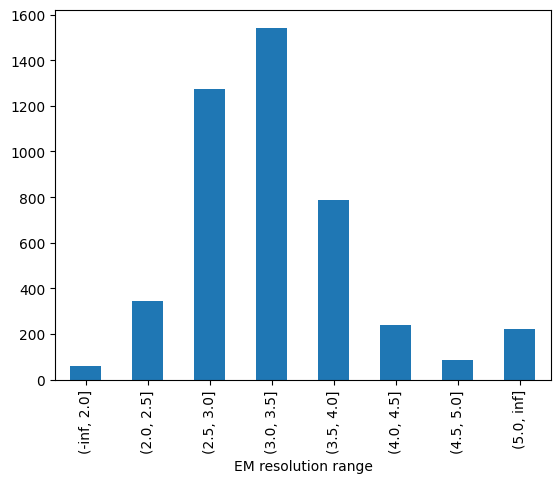

In [31]:
bin_cat = 'EM resolution range'
bin_range = [-float("inf"), 2, 2.5, 3, 3.5, 4, 4.5, 5, float("inf")]
pandas_plot_binned_float(list_of_results=em_results, column_to_group_by='em_resolution', bin_cat=bin_cat, bin_range=bin_range)